In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.optimize as opt
import csv
from arc import *
import matplotlib
import pandas as pd
matplotlib.rcParams['figure.dpi'] = 50
import pickle

## Optimize time-optimal single pulse gates

In [3]:
#Set phase guess and pulse time for Pupillo gate
# pulse_time= 7.63*1 # in Omega*t dimension-less units
cs = Cesium()
n=50
pulse_time= 7.65
resolution = 100 # number of phase steps in the pulse
# PhaseGuess = [(-1.2*np.sin(2*np.pi*x/pulse_time)-0.5) for x in np.linspace(0,pulse_time,resolution)] #input a phase profile guess 
PhaseGuess = [2*np.pi*0.1122, 1.0431, -0.7318, 0]
Omega_Rabi=2*np.pi*1.5 #2.785 #MHz
Blockade = 2*np.pi*7.5  #MHz
R_lifetime = cs.getStateLifetime(n=n,l=1,j=3/2,temperature=300, includeLevelsUpTo=70,s=0.5)*1e6
print(R_lifetime)

98.99837930254411


In [4]:
# Calculates both Bell state fidelity for input phases and return the output for optimization
def pulse_gate_infidelity_opt(phases, Blockade, delta):
    

    times=np.linspace(0,pulse_time*1,resolution+1) # Time in dimensionless units omega_rabi*t
    A = phases[0]
    w = phases[1]
    phi = phases[2]
    gamma = phases[3]
    phases = A*np.cos(w*times-phi)+gamma*times
    OmegaNorm=1 # normalize to 1 to keep timings consistant
    DecayRate=(1/R_lifetime)/(Omega_Rabi) # Decay rate normalized with Rabi frequency 
    B = Blockade/Omega_Rabi # normalize the blockade with the Rabi frequency
    Delta= delta/Omega_Rabi
    
    psi01 = np.array([1,0], complex)  # single atom state ground and Rydberg
    psi11 = np.array([1,0,0], complex) # two atom state ground-ground, ground-Rydberg, Rydberg-Rydberg 
    if B is None:  #None is infinite blockade
        psi11 = np.array([1,0], complex)  # dont need the 3rd element if blockade is infinite
        
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = OmegaNorm*np.exp(1j*phases[i])  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
        if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), Delta, Omega], [0, np.conj(Omega), Delta]])   # Hamiltonian for two atoms
            H11[2,2] += B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom

    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
    F_bell = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2  
    return 1-F_bell

In [6]:
#optimize the fidelity over the input phases using built-in scipy optimizer
phases_out=opt.minimize(fun=pulse_gate_infidelity_opt,x0=PhaseGuess, args=(Blockade, 0))

In [8]:
#check the optimized fidelity
1-pulse_gate_infidelity_opt(phases_out['x'], Blockade,0)

np.float64(0.9966018123035497)

In [11]:
1-pulse_gate_infidelity_opt(PhaseGuess, Blockade, 0)

np.float64(0.9696691757718425)

In [10]:
phases_out['x']

array([0.65536101, 1.292171  , 0.18073916, 0.17944176])

0.7122882597506719 1.0858492043401156 -0.600552363085593 0.07674338653877244


Text(0.5, 0, 'Time $t\\Omega_0$')

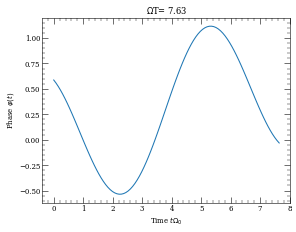

In [10]:
times_list = []
interpolation = []
phases = []
phases =phases_out['x']
A = phases[0]
w = phases[1]
phi = phases[2]
gamma = phases[3]

times = np.linspace(0, pulse_time,resolution + 1)
phases = A*np.cos(w*times-phi)+gamma*times
# for i in range(resolution):
    # times_list.append(np.linspace(0, 7.63,resolution + 1)[i])
    # phases.append(phases_out['x'][i]/2)
# fig, ax = plt.plot(figsize = (8,8))
print(A,w,phi,gamma)
plt.plot(times, phases)


plt.title("$\\Omega$T= 7.63")
plt.ylabel("Phase $\\varphi(t)$")
plt.xlabel("Time $t\Omega_0$")


In [12]:
result = {'time':times, 'phases':phases}

df = pd.DataFrame(result)
df.to_csv('phases.csv', index=False)
# with open('gate_phase_file.csv','w',newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(row_list)

In [26]:
# times_list = []
# times_list1 = []

# interpolation = []
# phases = []
# for i in range(resolution-1):
#     times_list.append(np.linspace(0,7.63,resolution + 1)[i])
#     phases.append((phases_out['x'][i]-phases_out['x'][i+1]/(7.63/100))*Omega_Rabi/(2*np.pi))
# # fig, ax = plt.plot(figsize = (8,8))

# plt.plot(times_list, phases)
# plt.ylabel("Detuning $\\Delta(t)$")
# plt.xlabel("Time $t\Omega_0$")

In [27]:
# times_list = []
# interpolation = []
# phases = []
# for i in range(resolution):
#     times_list.append(np.linspace(0,7.63,resolution + 1)[i])
#     phases.append(phases_out['x'][i])
# # fig, ax = plt.plot(figsize = (8,8))

# plt.plot(times_list, phases, linewidth=3)
# plt.ylabel("Phase $\\varphi(t)$")
# plt.xlabel("Time $t\Omega_0$")
# plt.tight_layout()
# plt.savefig("Phase profile.pdf", format="pdf")

In [28]:
pulse_time_in_ns=4*int(1e3*pulse_time/Omega_Rabi/4)
pulse_times_in_ns = range(0,pulse_time_in_ns,4)
len(pulse_times_in_ns)

pulse_time_in_ns=4*int(1e3*pulse_time/Omega_Rabi/4)
pulse_times_in_ns = range(0,pulse_time_in_ns,4)
phases_in_radians=np.interp(np.linspace(0,pulse_time,len(pulse_times_in_ns)),np.linspace(0,pulse_time,resolution),phases_out['x']/2)

row_list=  [('time_in_ns', 'phase_in_radians')] + list(list(zip(pulse_times_in_ns,phases_in_radians)))

with open('gate_phase_file.csv','w',newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)

In [14]:
sss

NameError: name 'sss' is not defined

In [ ]:
# #Set phase guess and pulse time for Pupillo gate
# pulse_time= 7.63*1 # in Omega*t dimension-less units
# # pulse_time= 14.32 
# resolution = 100 # number of phase steps in the pulse
# PhaseGuess = [(-1*np.cos(4*np.pi*x/pulse_time+0.7))+(-0.4*np.cos(8*np.pi*x/pulse_time-2.5+0.7))-0.5 for x in np.linspace(0,pulse_time,resolution)] #input a phase profile guess 
# Omega_Rabi=2*np.pi* 4.035 #2.785 #MHz
# Blockade = 2*np.pi*140  #MHz
# R_lifetime = 170 # microseconds

# times_list = []
# interpolation = []
# phases = []
# for i in range(resolution):
#     times_list.append(np.linspace(0, pulse_time,resolution + 1)[i])
#     phases.append(PhaseGuess[i])
# # fig, ax = plt.plot(figsize = (8,8))

# plt.plot(times_list, phases)
# plt.title("$\\Omega$T= {}".format(pulse_time))
# plt.ylabel("Phase $\\varphi(t)$")
# plt.xlabel("Time $t\Omega_0$")

In [ ]:
# Calculates both Bell state fidelity for input phases and return the output for optimization
def pulse_gate_infidelity_opt_amp(phases, Blockade):
    
    
    times=np.linspace(0,pulse_time*1,resolution+1) # Time in dimensionless units omega_rabi*t
    OmegaNorm=1 # normalize to 1 to keep timings consistant
    DecayRate=(1/R_lifetime)/(Omega_Rabi) # Decay rate normalized with Rabi frequency 
    B = Blockade/Omega_Rabi # normalize the blockade with the Rabi frequency
    dOmega=0.01
    
    psi01 = np.array([1,0], complex)  # single atom state ground and Rydberg
    psi11 = np.array([1,0,0], complex) # two atom state ground-ground, ground-Rydberg, Rydberg-Rydberg 
    if B is None:  #None is infinite blockade
        psi11 = np.array([1,0], complex)  # dont need the 3rd element if blockade is infinite
        
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = OmegaNorm*np.exp(1j*phases[i])  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
        if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])   # Hamiltonian for two atoms
            H11[2,2] = B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom
    F_bell = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2 
    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = (OmegaNorm+dOmega)*np.exp(1j*phases[i])  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
        if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])   # Hamiltonian for two atoms
            H11[2,2] = B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom
    F_bellP = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2 

    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
     
    return (1-F_bell)+abs(F_bellP-F_bell)*(1/0.01)

In [ ]:
phases_out=opt.minimize(fun=pulse_gate_infidelity_opt_amp,x0=PhaseGuess)

In [ ]:
1-pulse_gate_infidelity_opt(phases_out['x'])

In [ ]:
times_list = []
interpolation = []
phases = []
for i in range(resolution):
    times_list.append(np.linspace(0, pulse_time,resolution + 1)[i])
    phases.append(PhaseGuess[i])
# fig, ax = plt.plot(figsize = (8,8))

plt.plot(times_list, phases)
plt.title("$\\Omega$T= {}".format(pulse_time))
plt.ylabel("Phase $\\varphi(t)$")
plt.xlabel("Time $t\Omega_0$")

In [ ]:
times_list = []
interpolation = []
phases = []
for i in range(resolution):
    times_list.append(np.linspace(0, pulse_time,resolution + 1)[i])
    phases.append(phases_out['x'][i])
# fig, ax = plt.plot(figsize = (8,8))

plt.plot(times_list, phases)
plt.title("$\\Omega$T= {}".format(pulse_time))
plt.ylabel("Phase $\\varphi(t)$")
plt.xlabel("Time $t\Omega_0$")

In [ ]:
# Calculates both Bell state fidelity for input phases and return the output for optimization
def pulse_gate_infidelity_blockade_sensitivity(phases, blockade):
    
    
    times=np.linspace(0,pulse_time,resolution+1) # Time in dimensionless units omega_rabi*t
    OmegaNorm=1 # normalize to 1 to keep timings consistant
    DecayRate=(1/R_lifetime)/(Omega_Rabi) # Decay rate normalized with Rabi frequency 
    B = blockade/Omega_Rabi # normalize the blockade with the Rabi frequency

    
    psi01 = np.array([1,0], complex)  # single atom state ground and Rydberg
    psi11 = np.array([1,0,0], complex) # two atom state ground-ground, ground-Rydberg, Rydberg-Rydberg 
    if B is None:  #None is infinite blockade
        psi11 = np.array([1,0], complex)  # dont need the 3rd element if blockade is infinite
        
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = OmegaNorm*np.exp(1j*phases[i])  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
        if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])   # Hamiltonian for two atoms
            H11[2,2] = B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom

    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
    F_bell = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2  
    return 1-F_bell

In [19]:
def sample_pair_distances(
    n_samples=1000,
    sigma_r=0.0849,
    sigma_z=0.425,
    x_offset=2.5,
    rng=None
):
    """
    Monte Carlo distances between two point particles drawn from Gaussian clouds.

    Geometry:
      - Particle A: (x, y, z) ~ N( (0, 0, 0), diag([sigma_r^2, sigma_r^2, sigma_z^2]) )
      - Particle B: (x, y, z) ~ N( (x_offset, 0, 0), diag([sigma_r^2, sigma_r^2, sigma_z^2]) )

    Parameters
    ----------
    n_samples : int
        Number of particle pairs to simulate.
    sigma_r : float
        Standard deviation of the transverse (x,y) Gaussian for each cloud.
    sigma_z : float
        Standard deviation of the longitudinal z Gaussian for each cloud.
    x_offset : float
        Separation between the two cloud centers along +x (both have z0=0).
    rng : np.random.Generator or None
        Optional NumPy random generator for reproducibility.

    Returns
    -------
    distances : np.ndarray, shape (n_samples,)
        Euclidean separation distances for each pair.
    coords_a : dict
        Sampled coordinates for particle A: {'x','y','z'} each (n_samples,)
    coords_b : dict
        Sampled coordinates for particle B: {'x','y','z'} each (n_samples,)
    """
    if rng is None:
        rng = np.random.default_rng()

    # Particle A
    ax = rng.normal(loc=0.0, scale=sigma_r, size=n_samples)
    ay = rng.normal(loc=0.0, scale=sigma_r, size=n_samples)
    az = rng.normal(loc=0.0, scale=sigma_z, size=n_samples)

    # Particle B (shifted by x_offset along x; same z0=0)
    bx = rng.normal(loc=x_offset, scale=sigma_r, size=n_samples)
    by = rng.normal(loc=0.0,        scale=sigma_r, size=n_samples)
    bz = rng.normal(loc=0.0,        scale=sigma_z, size=n_samples)

    # Distances
    dx = ax - bx
    dy = ay - by
    dz = az - bz
    distances = np.sqrt(dx*dx + dy*dy + dz*dz)

    coords_a = {"x": ax, "y": ay, "z": az}
    coords_b = {"x": bx, "y": by, "z": bz}
    return distances, coords_a, coords_b
def sigma_r_um(atom_T_uK, U_trap_max_uK, w0_um):
    return (0.5) * np.sqrt(atom_T_uK / U_trap_max_uK)
def sigma_z_um(atom_T_uK, U_trap_max_uK, w0_um, wavelength_um):
    zR = np.pi * w0_um**2 / wavelength_um
    return zR * np.sqrt(atom_T_uK / (2 * U_trap_max_uK))
with open('blockades_symmetric.pkl', 'rb') as file:
    # Load the object from the file
    blockade_dict = pickle.load(file)
def find_blockade_Mrad(atom_name,n,d):
    blockades = blockade_dict['Cs'][str(n)]
    b_r = [l[0] for l in blockades]
    b_values = [l[1] for l in blockades]
    b = np.interp(d, b_r, b_values)
    return b*1e3*2*np.pi    	

In [47]:
trap_depth=300
T_atom = 15
shots =5000
atom_name= 'Cs'
atom_n = 50
Fs = []
for i in range(shots):
    #Monte Carlo on the position variation
    sep = sample_pair_distances(n_samples=1,sigma_r=sigma_r_um(atom_T_uK=T_atom, U_trap_max_uK=trap_depth, w0_um=1.2),
                                sigma_z=sigma_z_um(atom_T_uK=T_atom, U_trap_max_uK=trap_depth, w0_um=1.2, wavelength_um=1.064),
                                x_offset=2.5,rng=None)[0][0]
    B = find_blockade_Mrad(atom_name, int(atom_n), sep)
    # stark1 = 0
    # stark2 = 0
    # F_single = 1-pulse_gate_infidelity_opt(phases_out['x'], B)
    Fs.append(B/2/np.pi)
print(np.mean(Fs))

6.034567923128994


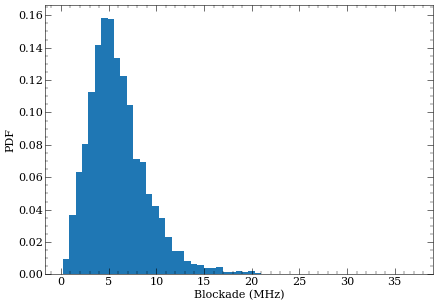

In [64]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(Fs, bins=55, density=True)
ax.set_xlabel('Blockade (MHz)', fontsize=16)
ax.set_ylabel('PDF',fontsize=16)
ax.tick_params(labelsize=16)
fig.savefig('Blockade_90F.jpg')

In [ ]:
# fidelity_vs_blockade = []
# blockade_list = np.linspace(2*2*np.pi,3.6*2*np.pi,50)
# blockade_list_MHz = np.linspace(2,3.6,50)
# for blockade in blockade_list:
#     fidelity =1-pulse_gate_infidelity_blockade_sensitivity(phases = phases_out['x'], blockade=blockade)
#     fidelity_vs_blockade.append(fidelity)

In [ ]:
fidelity_vs_blockade = []
blockade_list = np.linspace(2*2*np.pi,3.6*2*np.pi,50)
blockade_list_MHz = np.linspace(5,7,50)
for blockade in blockade_list:
    fidelity =1-pulse_gate_infidelity_blockade_sensitivity(phases = phases_out['x'], blockade=blockade)
    fidelity_vs_blockade.append(fidelity)

In [ ]:
# fidelity_vs_blockade = []
# blockade_list = np.linspace(1.78*2*np.pi,3.2*2*np.pi,13)
# blockade_list_MHz = np.linspace(1.8,3,13)
# for blockade in blockade_list:
#     fidelity =1-pulse_gate_infidelity_blockade_sensitivity(phases = phases_out['x'], blockade=blockade)
#     fidelity_vs_blockade.append(fidelity)
    

In [ ]:


matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(15, 10))
plt.ylabel("Fidelity")
plt.xlabel("Blockade (MHz)/(2pi)")
display(plt.plot(blockade_list_MHz, fidelity_vs_blockade))

In [ ]:
1-pulse_gate_infidelity_blockade_sensitivity(phases=phases_out['x'],blockade= 2*np.pi*2.3)

In [ ]:
# #Interpolate and check at high resolution 
# resolution_high = 300

# high_res_phases=np.interp(np.linspace(0,7.63,resolution_high),np.linspace(0,7.63,resolution),phases_out['x'])

In [ ]:
# # Calculates both Bell state fidelity for input phases and return the output for optimization at high resolution
# def pulse_gate_infidelity_opt_high_res(phases):

    
#     times=np.linspace(0,pulse_time,resolution_high+1)
#     OmegaNorm=1 # normalize to 1 to keep timings consistant
#     DecayRate=(1/R_lifetime)/(Omega_Rabi) # normalize with Rabi frequency 
#     B = Blockade/Omega_Rabi # normalize the blockade with the Rabi frequency

#     psi01 = np.array([1,0], complex)
#     psi11 = np.array([1,0,0], complex)
#     if B is None:
#         psi11 = np.array([1,0], complex)
        
#     for i in range(resolution_high):
#         dt = times[i+1]-times[i]
#         Omega = OmegaNorm*np.exp(1j*phases[i])
#         H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]])
#         if B is None:
#             H11 = np.sqrt(2)*H01
#         else:
#             H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])
#             H11[2,2] = B-1j*DecayRate
#         H01[1,1] = -1j*DecayRate/2
#         H11[1,1] = -1j*DecayRate/2
#         psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01
#         psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11
    
#     # Apply single qubit gates
#     phase = psi01[0]/np.abs(psi01[0])
#     psi01/=phase
#     psi11/=phase**2
    
#     #print(psi01)
#     #print(psi11)
    
#     F_bell = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2
#     return 1-F_bell

In [ ]:
# #Optimize at high resolution (takes a while)
# phases_out_high_res=opt.minimize(fun=pulse_gate_infidelity_opt_high_res,x0=high_res_phases)

In [ ]:
#optimized fidelity
# 1-pulse_gate_infidelity_opt_high_res(phases_out_high_res['x'])

In [ ]:
# #interpolated fidelity
# 1-pulse_gate_infidelity_opt_high_res(high_res_phases)

In [ ]:
# #Plot the two pulses on top of each other
# times_list = []
# interpolation = []
# phases = []
# for i in range(resolution_high):
#     times_list.append(np.linspace(0,7.63,resolution_high + 1)[i])
#     times_list.append(np.linspace(0,7.63,resolution_high + 1)[i+1])
#     for _ in range(2):
#         interpolation.append(high_res_phases[i])
#         phases.append(phases_out_high_res['x'][i])
# # fig, ax = plt.plot(figsize = (8,8))
# plt.plot(times_list, interpolation)

# plt.plot(times_list, phases)
# plt.ylabel("Phase $\\varphi(t)$")
# plt.xlabel("Time $t\Omega_0$")